In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/whatsapp-app-reviews-from-google-play-store/scrapped_WhatsApp Messenger_ID.csv
/kaggle/input/whatsapp-app-reviews-from-google-play-store/scrapped_WhatsApp Messenger_EN.csv


In [14]:
import pandas as pd

# 1. Veri setini oku
df = pd.read_csv(
    "/kaggle/input/whatsapp-app-reviews-from-google-play-store/scrapped_WhatsApp Messenger_EN.csv",
    low_memory=False
)

# 2. İlk 5 satırı incele
print(df.head())

# 3. Boş olan verileri kontrol et
print(df.isnull().sum())

# 4. Sadece gerekli sütunları alalım
df = df[['content', 'score', 'thumbsUpCount']].dropna()

# 5. Sentiment etiketini puanlara göre türetelim
def convert_sentiment(score):
    if score <= 2:
        return "negative"
    elif score == 3:
        return "neutral"
    else:
        return "positive"

df['sentiment'] = df['score'].apply(convert_sentiment)

# Kontrol: sentiment etiketlerinin dağılımı
print(df['sentiment'].value_counts())


                               reviewId       userName  \
0  66e8d3c5-93f4-4a9b-88d0-68e4c7287fec  A Google user   
1  0a62ddcc-587a-4771-b746-46664ef27d21  A Google user   
2  da83d914-4ec7-4a21-b282-92570cab96fb  A Google user   
3  305e0940-db49-4fe8-af86-19a9ddf0938f  A Google user   
4  1d4fa3fa-715e-486c-a6c7-40c223d182ed  A Google user   

                                           userImage  \
0  https://play-lh.googleusercontent.com/EGemoI2N...   
1  https://play-lh.googleusercontent.com/EGemoI2N...   
2  https://play-lh.googleusercontent.com/EGemoI2N...   
3  https://play-lh.googleusercontent.com/EGemoI2N...   
4  https://play-lh.googleusercontent.com/EGemoI2N...   

                                             content  score  thumbsUpCount  \
0  The new update is faulty can't send pics to fr...      1              2   
1  My account was restricted and later got retrie...      1              1   
2  Now a day photo sharing take more time . Kindl...      3              0   
3 

In [15]:
# Gereksiz sütunları kaldıralım (analize etkisi olmayanlar)
df = df[['content', 'score', 'thumbsUpCount', 'sentiment']]

# Eksik içerikleri temizleyelim (1 tane 'content' NaN vardı)
df = df.dropna(subset=['content'])

# Veri kümesinin boyutuna tekrar bakalım
print("Veri seti boyutu:", df.shape)


Veri seti boyutu: (94499, 4)


In [16]:
import re

# Küçük harfe çevir, sayıları ve özel karakterleri kaldır
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # sadece harf ve boşluk bırak
    text = re.sub(r"\s+", " ", text)  # birden fazla boşluğu teke indir
    return text.strip()

# Metinleri temizleyelim
df['clean_content'] = df['content'].apply(clean_text)

# Temizlenmiş metin örneği
print("Temiz içerik örneği:\n", df['clean_content'].iloc[0])


Temiz içerik örneği:
 the new update is faulty cant send pics to friends please review it quicklypls work on it u have updated it again the same thing again


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF vektörleştirici tanımla
vectorizer = TfidfVectorizer(max_features=5000)  # en fazla 5000 kelime al

# Metni sayısal vektörlere dönüştür
X = vectorizer.fit_transform(df['clean_content'])

# Hedef değişken (sentiment)
y = df['sentiment']

print("TF-IDF boyutu:", X.shape)


TF-IDF boyutu: (94499, 5000)


In [18]:
# Sadece 'negative' ve 'positive' etiketlerine sahip verileri al
df_binary = df[df['sentiment'].isin(['negative', 'positive'])]

# TF-IDF tekrar çalıştır (çünkü önceki vektör tüm sınıfları kapsıyordu)
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_binary = TfidfVectorizer(max_features=5000)
X_binary = vectorizer_binary.fit_transform(df_binary['clean_content'])
y_binary = df_binary['sentiment']

print("Veri seti boyutu:", X_binary.shape)


Yeni veri seti boyutu: (81625, 5000)


In [19]:
from sklearn.model_selection import train_test_split

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X_binary, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)

print("Eğitim verisi boyutu:", X_train_b.shape)
print("Test verisi boyutu:", X_test_b.shape)


Eğitim verisi boyutu: (65300, 5000)
Test verisi boyutu: (16325, 5000)


Doğruluk Oranı: 0.8116998468606432

Sınıflandırma Raporu:
               precision    recall  f1-score   support

    negative       0.79      0.90      0.84      9196
    positive       0.84      0.70      0.76      7129

    accuracy                           0.81     16325
   macro avg       0.82      0.80      0.80     16325
weighted avg       0.82      0.81      0.81     16325



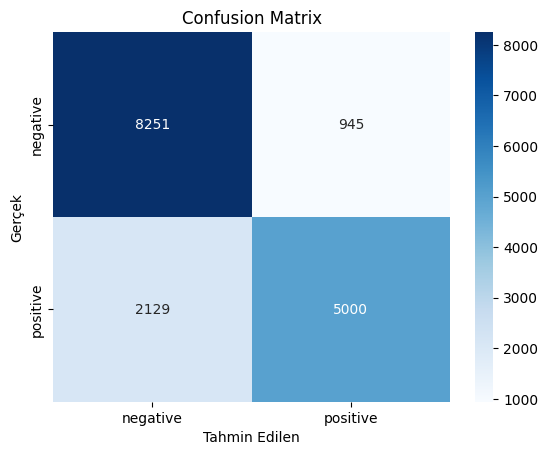

In [39]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Model oluştur ve eğit
nb_model_binary = MultinomialNB()
nb_model_binary.fit(X_train_b, y_train_b)

# Tahmin yap
y_pred_b = nb_model_binary.predict(X_test_b)

# Başarı ölç
print("Doğruluk Oranı:", accuracy_score(y_test_b, y_pred_b))
print("\nSınıflandırma Raporu:\n", classification_report(y_test_b, y_pred_b))

# Confusion matrix çiz (sadece 2 sınıf)
cm_b = confusion_matrix(y_test_b, y_pred_b, labels=["negative", "positive"])
sns.heatmap(cm_b, annot=True, fmt='d', cmap="Blues", xticklabels=["negative", "positive"], yticklabels=["negative", "positive"])
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.title("Confusion Matrix")
plt.show()


In [22]:
import numpy as np

# TF-IDF vektörizer'dan kelime listesi al
feature_names = vectorizer_binary.get_feature_names_out()

# Her sınıfın ortalama TF-IDF skorunu hesapla
positive_indices = np.where(y_train_b == 'positive')[0]
negative_indices = np.where(y_train_b == 'negative')[0]

positive_tfidf_mean = X_train_b[positive_indices].mean(axis=0).A1
negative_tfidf_mean = X_train_b[negative_indices].mean(axis=0).A1

# En yüksek ortalama skora sahip 20 kelimeyi göster
top_pos_idx = positive_tfidf_mean.argsort()[-20:][::-1]
top_neg_idx = negative_tfidf_mean.argsort()[-20:][::-1]

print("📈 En Anlamlı Pozitif Kelimeler:")
for i in top_pos_idx:
    print(f"{feature_names[i]}: {positive_tfidf_mean[i]:.4f}")

print("\n📉 En Anlamlı Negatif Kelimeler:")
for i in top_neg_idx:
    print(f"{feature_names[i]}: {negative_tfidf_mean[i]:.4f}")


📈 En Anlamlı Pozitif Kelimeler:
the: 0.0679
to: 0.0639
and: 0.0595
it: 0.0524
is: 0.0505
app: 0.0501
for: 0.0392
this: 0.0360
whatsapp: 0.0352
you: 0.0350
in: 0.0344
very: 0.0333
good: 0.0331
of: 0.0322
but: 0.0303
that: 0.0301
can: 0.0300
its: 0.0296
my: 0.0292
with: 0.0285

📉 En Anlamlı Negatif Kelimeler:
the: 0.0743
to: 0.0661
and: 0.0524
it: 0.0524
my: 0.0515
is: 0.0463
whatsapp: 0.0451
not: 0.0404
this: 0.0387
app: 0.0344
of: 0.0306
in: 0.0301
on: 0.0301
but: 0.0273
have: 0.0272
update: 0.0271
for: 0.0267
you: 0.0254
its: 0.0245
that: 0.0238


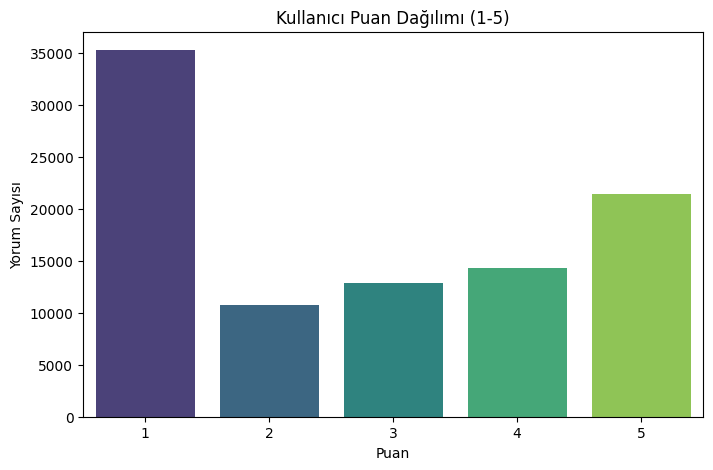

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.countplot(data=df, x="score", palette="viridis")
plt.title("Kullanıcı Puan Dağılımı (1-5)")
plt.xlabel("Puan")
plt.ylabel("Yorum Sayısı")
plt.show()


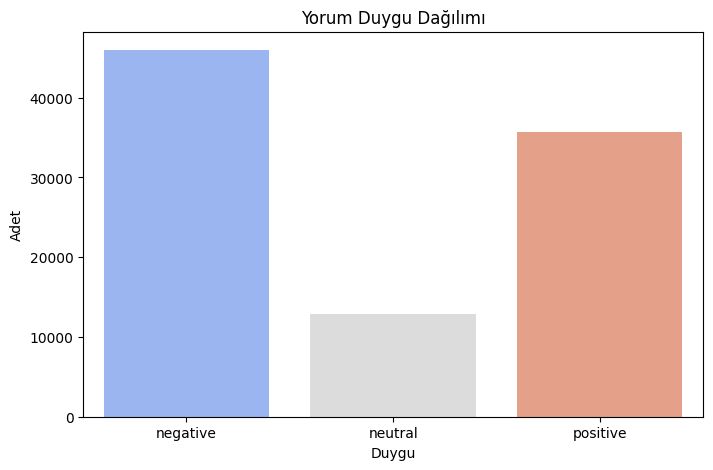

In [28]:
plt.figure(figsize=(8,5))
sns.countplot(data=df, x="sentiment", order=['negative', 'neutral', 'positive'], palette="coolwarm")
plt.title("Yorum Duygu Dağılımı")
plt.xlabel("Duygu")
plt.ylabel("Adet")
plt.show()


In [30]:
# Yorum uzunluklarına göre sıralayıp en uzun olanı bul
df["comment_length"] = df["clean_content"].apply(lambda x: len(str(x)))
longest_comment = df.loc[df["comment_length"].idxmax()]

print("En Uzun Yorum:")
print(f"Puan: {longest_comment['score']}")
print(f"Uzunluk: {longest_comment['comment_length']} karakter")
print(f"Yorum:\n{longest_comment['content']}")

En Uzun Yorum:
Puan: 5
Uzunluk: 1711 karakter
Yorum:
I personally feel like this app app is just awesome because this app contains of all the things like text many images emojis this app also makes sure that our all messages ,videos text ,and any other sent or received items are secured with the Google security it protects them and Hides and conceals it and it has now a good feature called you can also delete this message if we do any mistake it conceals it and it helps us by doing and making a work easier and it also has a voice message button we have to just click on it and then we can say whatever we want to say and the voice is also clear I feel like WhatsApp is just my one of the favourite app and this was just awesome first I was just bored with this but now I am addicted to it I want to read this app as not only good the best awesome and whatever I want to say I just can't say many words this is speechless actually I am just crazy about this app and now there is a new feature li

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


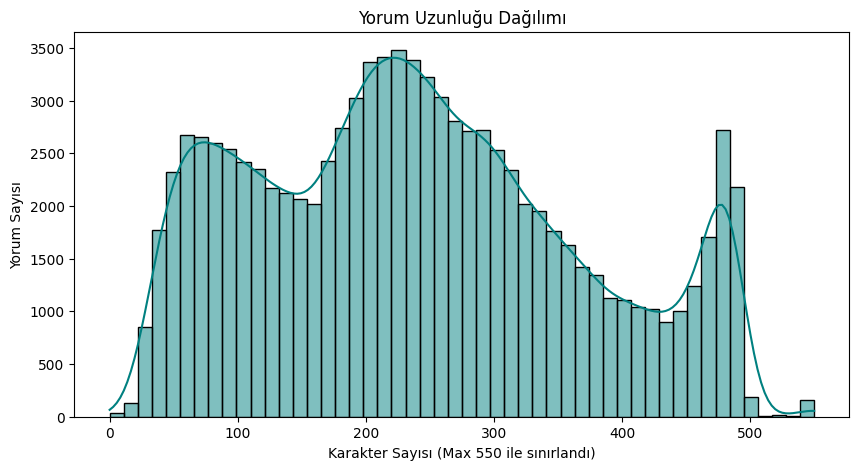

In [37]:
import numpy as np

# Temizlenmiş yorum sütunu yoksa oluştur
if "clean_content" not in df.columns:
    df["clean_content"] = df["content"].astype(str).str.lower().str.strip()

# Yorum uzunluğunu hesapla
df["comment_length"] = df["clean_content"].apply(len)

# Sonsuz değerleri NaN ile değiştir (inplace olmadan)
df["comment_length"] = df["comment_length"].replace([np.inf, -np.inf], np.nan)

# Çok uzun yorumları 1000 karakter ile sınırlayalım
df["comment_length"] = df["comment_length"].apply(lambda x: x if x <= 550 else 550)

# NaN değerleri temizle
lengths = df["comment_length"].dropna()

# Grafik çizimi
plt.figure(figsize=(10,5))
sns.histplot(lengths, bins=50, kde=True, color="teal")
plt.title("Yorum Uzunluğu Dağılımı")
plt.xlabel("Karakter Sayısı (Max 550 ile sınırlandı)")
plt.ylabel("Yorum Sayısı")
plt.show()



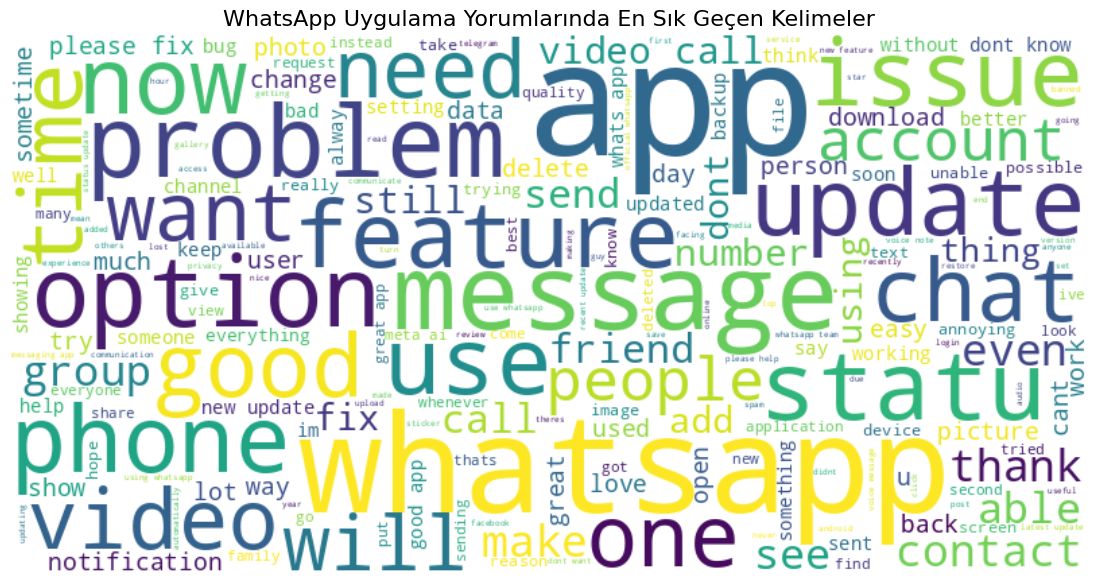

In [38]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Kelime bulutu oluşturulacak metin
text = ' '.join(df['clean_content'].dropna())

# WordCloud oluştur
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Görselleştirme
plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WhatsApp Uygulama Yorumlarında En Sık Geçen Kelimeler", fontsize=16)
plt.show()
